In [36]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import math

MOMENT_THRESH = 0.2
SE1 = np.ones((3, 3), np.uint8)
SE2 = np.ones((5, 5), np.uint8)
SE3 = np.ones((13, 13), np.uint8)
RESIZE_WIDTH = 600

def binaryImageCanny(grayImage):
    canny = cv2.Canny(grayImage, 20, 150)
    
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, SE1)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, SE2)
    
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(canny, contours, -1, (255, 255, 255), -1)
       
    return canny

def binaryImageAdaptiveThresh(grayImage, c=2):
    blured = cv2.medianBlur(grayImage, 5)
    thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, c)
    
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, SE1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, SE2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, SE1)
    
    thresh = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(thresh, [contour], 0, (255, 255, 255), -1)
    thresh = cv2.bitwise_not(thresh)

    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, SE3)

    thresh = cv2.bitwise_not(thresh)
    
    return thresh

def resizeFixRate(image, width):
    img_width = image.shape[1]
    imgRatio = width / img_width 
    return cv2.resize(image, dsize=(0, 0), fx=imgRatio, fy=imgRatio, interpolation=cv2.INTER_LINEAR)

def getContours(binaryImage):
    return cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def show(image_to_show):
    cv2.imshow("image to show", image_to_show)
    cv2.waitKey()
    cv2.destroyAllWindows()

def compute_contour_center(contour):
    m = cv2.moments(contour)
    cx = int(m["m10"] / m["m00"])
    cy = int(m["m01"] / m["m00"])
    return cx, cy

def min_max_from_contour(contour, center):
    min_d = 99999
    max_d = -1
    center_x = center[0]
    center_y = center[1]
    for cx, cy in contour:
        x_diff = center_x - cx
        y_diff = center_y - cy
        distance = math.sqrt((x_diff * x_diff) + (y_diff * y_diff))

def register_pills_image(image_path):
    pills_combination = {}
    pills_combination['name'] = os.path.basename(open(image_path).name)
    
    tmpl_image = cv2.imread(image_path)
    tmpl_image = resizeFixRate(tmpl_image, RESIZE_WIDTH)
    pills_combination['image'] = copy.deepcopy(tmpl_image)
    
    tmpl_gray = cv2.cvtColor(tmpl_image, cv2.COLOR_BGR2GRAY)
    tmpl_binary = binaryImageAdaptiveThresh(tmpl_gray)
    show(tmpl_binary)
    tmpl_contours, _ = getContours(tmpl_binary)
    pills_combination['contours'] = []
    pills_combination['center'] = []
    pills_combination['offset'] = []
    pills_combination['relative_size'] = []
    
    # test_image = copy.deepcopy(tmpl_image)
    # cv2.drawContours(test_image, tmpl_contours, -1, [255,255,255], 1)
    # show(test_image)
    
    max_contour_len = len(max(tmpl_contours, key=lambda x : len(x)))
    for i, contour in enumerate(tmpl_contours):
        print(len(contour))
        if len(contour) < max_contour_len/4: # 그림자, 잡음으로 생긴 blob제거 따라서 사진을 최대한 알약이 크게 보이게 찍는다.
            continue

        tmp = copy.deepcopy(tmpl_image)
        # cv2.drawContours(tmp, [contour], 0, [255, 255, 255], 1)
        # 
        # cv2.imshow("blob " + str(i), tmp)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        rect = cv2.boundingRect(contour)
        x, y, w, h = rect
        # box = cv2.rectangle(origin_image, (x,y), (x+w,y+h), (0,0,255), 1)
        cropped = tmp[y: y+h, x: x+w]
        cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        cropped_binary = binaryImageCanny(cropped_gray) # 여기는 일단 이렇게 해보기
        cv2.imshow("binary", cropped_binary)
        cropped_contours, _ = getContours(cropped_binary)
        
        cv2.drawContours(tmp, cropped_contours, 0, [255, 255, 255], 1, offset=(x, y))
        pills_combination['contours'].append(cropped_contours[0])
        pills_combination['offset'].append((x, y))
        pills_combination['center'].append(compute_contour_center(cropped_contours[0]))

        cv2.imshow(pills_combination['name'] + " blob " + str(i), tmp)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return pills_combination


def compare_pill(tmpl_pills, user_pills):
    result = {}
    for i, tmpl_contour in enumerate(tmpl_pills['contours']):
        tmpl_image = copy.deepcopy(tmpl_pills['image'])
        tmpl_offset = tmpl_pills['offset'][i]
        cv2.drawContours(tmpl_image, [tmpl_contour], 0,  [255, 255, 255], 1, offset=tmpl_offset)
        result[i] = []
        for j, user_contour in enumerate(user_pills['contours']):
            moment = cv2.matchShapes(tmpl_contour, user_contour, cv2.CONTOURS_MATCH_I3, 0)
            if moment > MOMENT_THRESH: # MOMENT_THRESH보다 작으면 같은 모양으로 취급
                continue
            # tmpl, user contour index
            result[i].append(j)            
            user_image = copy.deepcopy(user_pills['image'])
            user_offset = user_pills['offset'][j]
            cv2.drawContours(user_image, [user_contour], 0,  [255, 255, 255], 1, offset=user_offset)
            
            cv2.imshow("tmpl" + str(moment), tmpl_image)
            cv2.imshow("user" + str(moment), user_image)

            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
        

In [37]:
tmpl_pills = register_pills_image("images/tmpl_pills.jpg")
user_pills = register_pills_image("images/user_pills.jpg")
# user_pills1 = register_pills_image("images/user_pills1.jpg")

150
6
4
9
244
13
106


In [32]:

compare_pill(tmpl_pills, user_pills)


In [4]:
#s pill_2.jpg
tmpl_image = cv2.imread("images/pills_1.jpg")
tmpl_image = resizeFixRate(tmpl_image, RESIZE_WIDTH)

grayImage = cv2.cvtColor(tmpl_image, cv2.COLOR_BGR2GRAY)
binaryImage = binaryImageAdaptiveThresh(grayImage)

tmpl_contours, hirarachy = getContours(binaryImage)

# for contour in contours:
#     contour_image = cv2.drawContours(tmpl_image, [contour], 0, (255, 255, 255), 2)
# 
# plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))

find_image = cv2.imread("images/pill1_11.PNG")
find_image = resizeFixRate(find_image, RESIZE_WIDTH)

grayImage = cv2.cvtColor(find_image, cv2.COLOR_BGR2GRAY)
binaryImage = binaryImageAdaptiveThresh(grayImage)

find_contours, find_hirarachy = getContours(binaryImage)


min_moment = 1000000
similar = None

import copy
for c in tmpl_contours:
    origin = copy.deepcopy(tmpl_image)
    cv2.drawContours(origin, [c], 0,  [255, 255, 255], 2)
    
    moment = cv2.matchShapes(c, find_contours[0], cv2.CONTOURS_MATCH_I3, 0)
    if min_moment >= moment:
        min_moment = moment
        similar = c
    cv2.imshow("dd", origin)
    cv2.imshow("dd2", find_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
origin2 = copy.deepcopy(tmpl_image)
cv2.drawContours(origin2, [similar], 0,  [255, 255, 255], 2)
show(origin2)


In [18]:
# import copy
# for c in contours:
#     origin = copy.deepcopy(origin_image)
#     stencil = np.zeros(origin.shape).astype(origin.dtype)
#     cv2.fillPoly(stencil, [c], [255, 255, 255])
#     result = cv2.bitwise_and(origin, stencil)
#     # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#     cv2.imshow("dd", result)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

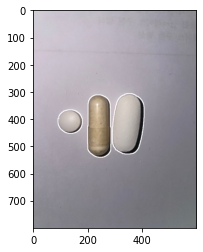

In [43]:
image = cv2.imread("images/pills_1.jpg")
image = resizeFixRate(image, RESIZE_WIDTH)
origin_image = resizeFixRate(image, RESIZE_WIDTH)

grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binaryImage = binaryImageAdaptiveThresh(grayImage)

contour_image=None
contours, hirarachy = getContours(binaryImage)
for contour in contours:
    contour_image = cv2.drawContours(image, [contour], 0, (255, 255, 255), 2)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))

test_pill = None
test_contour = None
import copy
for c in contours:
    origin = copy.deepcopy(origin_image)
    stencil = np.zeros(origin.shape).astype(origin.dtype)
    cv2.fillPoly(stencil, [c], [255, 255, 255])
    result = cv2.bitwise_and(origin, stencil)
    # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    test_pill = result
    test_contour = [c]
    cv2.imshow("dd", result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [9]:
min_moment = 1000000
similar = None

for c in contours:
    origin = copy.deepcopy(origin_image)
    cv2.drawContours(origin, [c], 0,  [255, 255, 255], 2)
    
    moment = cv2.matchShapes(c, test_contour[0], cv2.CONTOURS_MATCH_I3, 0)
    if min_moment >= moment:
        min_moment = moment
        similar = [c]
    # cv2.imshow("dd", origin)
    # cv2.imshow("dd2", test_pill)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
origin2 = copy.deepcopy(origin_image)
cv2.drawContours(origin2, similar, 0,  [255, 255, 255], 2)
cv2.imshow("d", origin2)


In [ ]:
for i,c in enumerate(contours):
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    box = cv2.rectangle(origin_image, (x,y), (x+w,y+h), (0,0,255), 2)
    cropped = origin_image[y: y+h, x: x+w]
    cv2.imshow("Show Boxes", cropped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite("blobby"+str(i)+".png", cropped)